# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Detect environment

In [2]:
from pkg.marker_config import *
from pkg.environment_builder import *
from pkg.geometry import *
from pkg.utils import *

init_stereo()
aruco_map, dictionary = get_aruco_config()

ROBOTS_ON_SCENE = [("indy0", RobotType.indy7_robot), ("panda1", RobotType.panda_robot)]
JOINT_NAMES_DEFINED = ['indy0_joint0', 'indy0_joint1', 'indy0_joint2', 'indy0_joint3', 'indy0_joint4', 'indy0_joint5',
                   'panda1_joint1', 'panda1_joint2', 'panda1_joint3', 'panda1_joint4', 
                   'panda1_joint5', 'panda1_joint6', 'panda1_joint7']
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,np.pi/2])

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
xyz_rpy_robots, xyz_rvec_cams, env_gen_dict, objectPose_dict, corner_dict, color_image  = \
    detect_environment(
        aruco_map, dictionary, robot_tuples=ROBOTS_ON_SCENE,
        env_dict={'floor': CallHolder(GeoBox, ["center", "orientation"], BLH=(1.52,0.72,0.01)),
                  'wall':CallHolder(GeoBox, ["center", "orientation"], BLH=(3,3,0.01))},
        camT_dict={"cam0":np.identity(4), "cam1": T_c12},
        ref_name='floor')

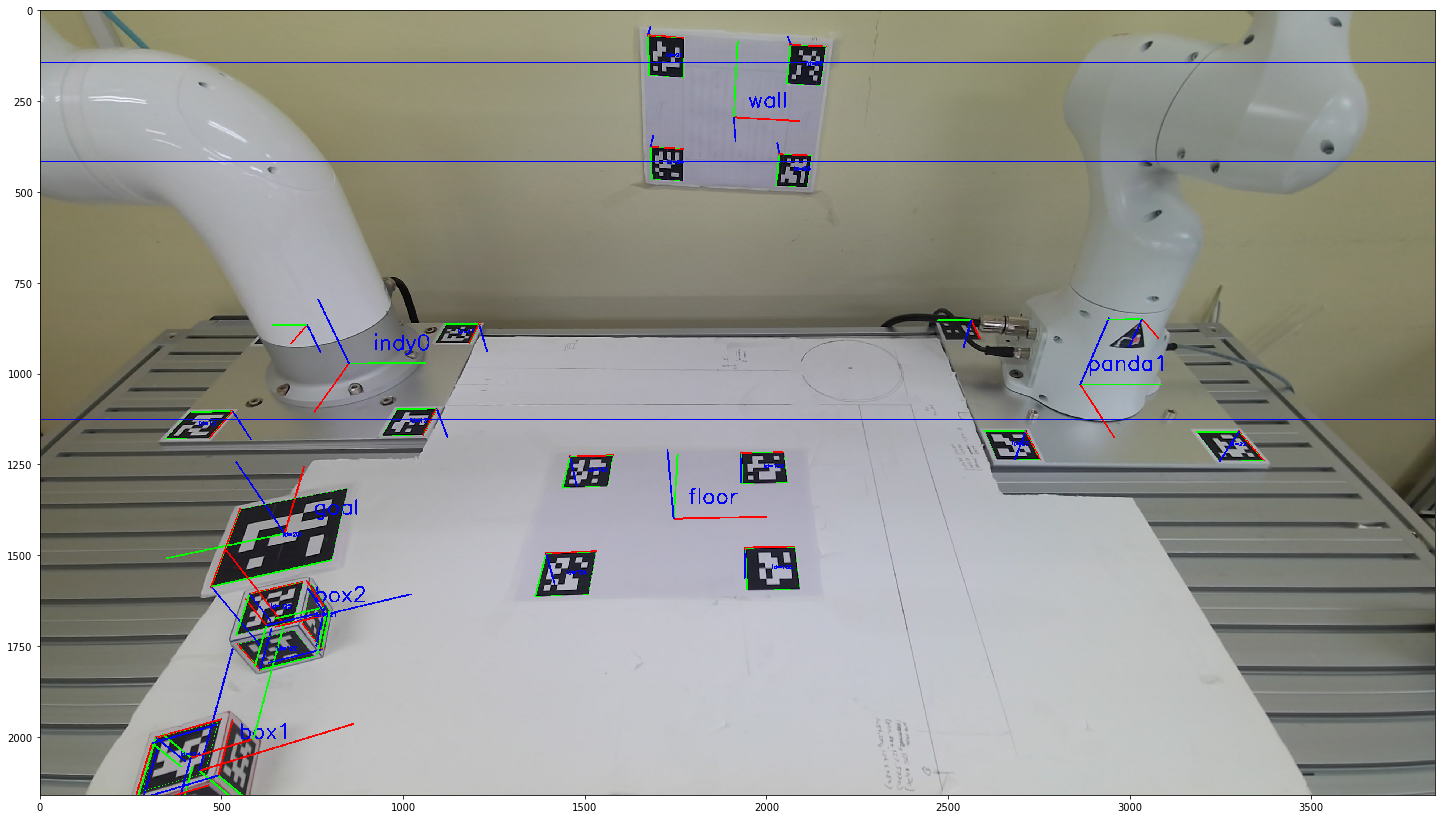

In [4]:
plt.figure(figsize=(25,15))
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

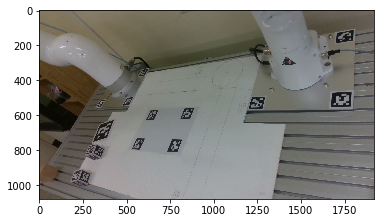

In [5]:
plt.imshow(get_rs_image()[:,:,[2,1,0]])

In [6]:
# with open('config.pkl', 'wb') as f:
#     pickle.dump({"objectPose_dict":objectPose_dict, "corner_dict":corner_dict}, f)

In [7]:
# disconnRobotType.indy7_robotect_stereo()

# Define robot config

In [8]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer(ROBOTS_ON_SCENE, xyz_rpy_robots)

vel_scale, acc_scale = 0.5, 0.5
custom_limits = {}
XacroCustomizer.update_limit_dict(custom_limits, "vel", JOINT_NAMES_DEFINED, 
                                  vel_scale * np.deg2rad(
        [150, 150, 150, 180, 180, 180, 150, 150, 150, 150, 180, 180, 180]))
XacroCustomizer.update_limit_dict(custom_limits, "acc", JOINT_NAMES_DEFINED, 
                                  acc_scale * np.deg2rad(
        [360]*len(JOINT_NAMES_DEFINED)))
custom_limits['panda1_joint1']['lower'], custom_limits['panda1_joint1']['upper'] = -2.75, 2.75
custom_limits['panda1_joint2']['lower'], custom_limits['panda1_joint2']['upper'] = -1.70, 1.70
custom_limits['panda1_joint3']['lower'], custom_limits['panda1_joint3']['upper'] = -2.75, 2.75
custom_limits['panda1_joint4']['lower'], custom_limits['panda1_joint4']['upper'] = -2.9, -0.1
custom_limits['panda1_joint5']['lower'], custom_limits['panda1_joint5']['upper'] = -2.75, 2.75
custom_limits['panda1_joint6']['lower'], custom_limits['panda1_joint6']['upper'] = 0.1, 3.6
custom_limits['panda1_joint7']['lower'], custom_limits['panda1_joint7']['upper'] = -2.75, 2.75


JOINT_NAMES, LINK_NAMES, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        joint_offset_dict={},
        joint_limit_dict=custom_limits)
refine_meshes()
xcustom.start_rviz()

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


# Create Graph

In [9]:
from pkg.constraint_graph import *
from pkg.constants import *
from pkg.plot_utils import *
from pkg.utils import *

rospy.init_node('task_planner', anonymous=True)

In [10]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = False, connect_indy = False)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

add_cam_poles(graph, xyz_rvec_cams)
add_objects_gen(graph, env_gen_dict)

if graph.connect_indy:
    graph.indy.connect_and(graph.indy.joint_move_to,np.rad2deg(ZERO_JOINT_POSE[graph.indy_idx]))
if graph.connect_panda:
    graph.panda.move_joint_interpolated(ZERO_JOINT_POSE[graph.panda_idx], N_div=300)
    graph.panda.set_k_gain(70)
    graph.panda.set_d_gain(7)

## add custom meshes

In [11]:
graph.add_geometry_items([
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm2_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi*2/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox((0, 0,0.0675), (0.05,0.05,0.130), orientation=(0,0,0), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.3), collision=True),
                           GeoSegment((-0.1,0,0.03), (0,np.pi/2,0), 0.2, 0.05, name="indy0_plug", link_name="indy0_link0",
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True),
                           GeoSegment((-0.05,0,0.03), (np.pi/2,0.0,0.0), 0.3, 0.05, name="cableset", link_name="panda1_link0", 
                                      urdf_content=graph.urdf_content, color=(0,1,0,0.3), display=True, collision=True)
    ], fixed=True)

## Register binders

In [12]:
graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,112e-3], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=(0, 0,0.132), link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

# Add objects

In [13]:
MOVABLE_GENERATORS = {'box1': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.05, 0.05,0.05), color=(0.8,0.3,0.3,1)), 
                 'box2': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.5, 0.05,0.5), color=(0.3,0.3,0.8,1)), 
#                  'box3': CallHolder(GeoSphere, ["center", None], radius=0.15, color=(0.8,0.8,0.0,0.3), collision=False), 
                 'goal': CallHolder(GeoBox, ["center", "orientation"], BLH=(0.1, 0.1,0.01), color=(0.8,0.0,0.0,1))}
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.008], direction=[0,0,1])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True)}
# ,
#                'box2': dict(_type=BoxAction, hexahedral=True)

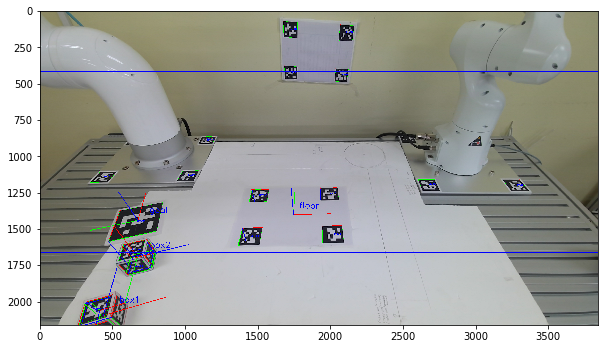

In [14]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
put_point_dict = register_objects(graph, objectPose_dict_mv, MOVABLE_GENERATORS, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=("floor", objectPose_dict["floor"]), link_name="world")

plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

# Set RVIZ

In [15]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)
    

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


# Search Graph (Custom Robots)

In [16]:
graph.build_graph()

In [17]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
    objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
graph.show_pose(ZERO_JOINT_POSE)

In [18]:
dt_sim = 0.04
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                      (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                       else ZERO_JOINT_POSE))

goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
# goal_nodes = goal_nodes[3:4]

graph.search_graph_mp(
    initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
    tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
print(gtimer)


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.54 s, steps/err: 36(298.548221588 ms)/0.0126220991056)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.67 s, steps/err: 64(558.556079865 ms)/0.24793785515)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.98 s, steps/err: 193(884.897947311 ms)/0.0860987116702)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.03 s, steps/err: 250(987.268924713 ms)/0.277921834647)node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.06 s, steps/err: 125(724.469900131 ms)/0.360778166936)node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.17 s, steps/err: 227


fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.28 s, steps/err: 32(373.342990875 ms)/0.530433590419)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (3.4 s, steps/err: 250(1783.45799446 ms)/0.1475674326)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (3.54 s, steps/err: 185(1221.33612633 ms)/0.0716549980405)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (3.58 s, steps/err: 232(1491.4689064 ms)/0.235740355198)node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.73 s, steps/err: 250(1083.00280571 ms)/0.248016219859)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (3.98 s, steps/err: 86(


fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.87 s, steps/err: 59(514.192819595 ms)/0.32779512853)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (5.93 s, steps/err: 97(837.116956711 ms)/0.330657079128)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (6.21 s, steps/err: 250(1435.97698212 ms)/0.321249427407)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (6.29 s, steps/err: 56(480.001926422 ms)/0.94039372911)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (6.34 s, steps/err: 54(486.866950989 ms)/0.306834197637)node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (6.77 s, step

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (8.12 s, steps/err: 33(399.323940277 ms)/0.246397318957)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (8.19 s, steps/err: 74(436.205148697 ms)/0.307027756634)======================================================================================================================================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (8.33 s, steps/err: 85(618.777990341 ms)/0.529520066388)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (8.58 s, steps/err: 35(417.806148529 ms)/0.378704875791)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (8.61 s, steps/err: 32(416.186094284 ms)/1.12967852

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (10.53 s, steps/err: 250(1406.54706955 ms)/0.0509646094707)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (10.58 s, steps/err: 66(523.185014725 ms)/0.305795574984)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (10.67 s, steps/err: 97(565.148830414 ms)/0.238177549173)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 10-> (10.87 s, steps/err: 80(538.888216019 ms)/0.390808444203)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 10-> (10.9 s, steps/err: 47(402.575969696 ms)/0.224378401542)node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (10.91 s, steps/err: 187(1037.06502914 ms)/0.0503988287452)

node: (('box1',


fail - Goal cost:1->0 / Init cost:1->2 / branching: 12-> (13.14 s, steps/err: 95(829.046964645 ms)/0.257107460937)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 11-> (13.21 s, steps/err: 39(406.252861023 ms)/0.946998970109)
success - Goal cost:1->1 / Init cost:1->1 / branching: 11->14 (13.23 s, steps/err: 25(265.752077103 ms)/0.0009490715651)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 13-> (13.25 s, steps/err: 181(1035.6991291 ms)/0.0547316457273)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 11->15 (13.3 s, steps/err: 24(346.57907486 ms)/0.000767209438495)===============================================================================================================================


fail - Goal cost:1->0 / Init cost:1->2 / branching: 14-> (15.47 s, steps/err: 250(1264.58191872 ms)/0.0378081847606)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)
===== terminate =====
===== terminate =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 16-> (15.79 s, steps/err: 250(1141.43705368 ms)/0.046473567127)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 16-> (15.8 s, steps/err: 250(989.632129669 ms)/0.0487607933383)=====================
===== terminate =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)
===== terminate =====
search_graph_mp: 	15863.0 ms/1 = 15862.885 ms (15862.885/15862.885)
init_search: 	4.0 ms/1 = 4.116 ms (4.116/4.116)
score_graph: 	2.0 ms/8 = 0.297 ms (0.23/0.453)
reset_valid_node: 	1.0 ms/201 = 0.005 ms (0.001/0.026)
check_goal: 	0.0 ms/219 = 0.001 ms (0.0/0.023)
get_valid_neighbor: 	0.0 ms/18 = 0.009 ms (0.007/0.011)
ad

In [19]:
print(graph.search_counter.value)
print(gtimer)

148
search_graph_mp: 	15863.0 ms/1 = 15862.885 ms (15862.885/15862.885)
init_search: 	4.0 ms/1 = 4.116 ms (4.116/4.116)
score_graph: 	2.0 ms/8 = 0.297 ms (0.23/0.453)
reset_valid_node: 	1.0 ms/201 = 0.005 ms (0.001/0.026)
check_goal: 	0.0 ms/219 = 0.001 ms (0.0/0.023)
get_valid_neighbor: 	0.0 ms/18 = 0.009 ms (0.007/0.011)
add_node_queue_leafs: 	6.0 ms/1 = 6.297 ms (6.297/6.297)
find_schedules: 	3.0 ms/1 = 2.505 ms (2.505/2.505)
sort_schedule: 	0.0 ms/1 = 0.015 ms (0.015/0.015)



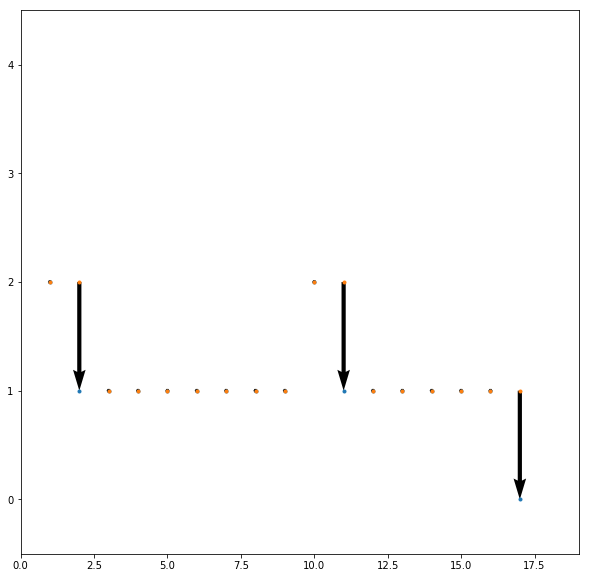

In [20]:
graph.quiver_snodes()

# Replay schedule

In [21]:
N_fullstep = 500
dt_vis = 0.01
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted[:], range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(
        graph.snode_dict[0].state, graph.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_vis, N_step=N_fullstep, 
                     vel_conv=1e-2, err_conv=1e-3, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 10, 11, 14, 17]

--------------------
10-(('box1', 'back_p', 'floor'),)

--------------------
11-(('box1', 'front_p', 'vac2'),)

--------------------
14-(('box1', 'front_p', 'vac2'),)

--------------------
17-(('box1', 'back_p', 'goal_bd'),)


# Execute traj online

In [46]:
schedule = schedule_sorted[0]
state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
obs_names = ["box3"]

with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
        RvizPublisher(graph, obs_names) as rviz_pub:
    graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=True, 
                                  obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)

AttributeError: ConstraintGraph instance has no attribute 'indy'

# onestep

In [39]:
def loop_process():
    loop_process.stop_now = False
    while not loop_process.stop_now:
        print("wait for button input")
        graph.indy.connect_and(graph.indy.wait_di, 16)
        if loop_process.stop_now:
            break
        kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
        objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
            detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
        objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
        xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
            objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
        update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
        graph.show_pose(ZERO_JOINT_POSE)
        
        dt_sim = 0.04
        T_step = 10
        N_fullstep = int(T_step / dt_sim)
        gtimer.reset()
        initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))

        goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")

        graph.search_graph_mp(
            initial_state = initial_state, goal_nodes = goal_nodes,
            tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
            terminate_on_first = True, N_search = 100, N_loop=1000,
            display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
            **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)

        schedule = schedule_sorted[0]
        state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
        obs_names = ["box3"]

        with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
                RvizPublisher(graph, obs_names) as rviz_pub:
            graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                          vel_conv=1e-2, err_conv=1e-3, T_step = 50, on_rviz=False, 
                                          obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
    print("===========================================")
    print("=================KILLED====================")
    print("===========================================")
t_loop = Thread(target=loop_process)
t_loop.start()

wait for button input
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.44 s, err: 0.685238307896)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'back_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.98 s, err: 0.000952943417618)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.1 s, err: 0.130097449087)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.28 s, err: 0.0730680494845)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.43 s, err: 0.0751908029837)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.86 s, err: 0.0931139914436)
node: (('box1', 'left_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.92 s, err: 0.22433769414)======================================================================================================================================================

node: (('box1', 'left_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (1.97 s, err: 0.0311672527169)
node: (('box1', 'right_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (2.43 s, err: 0.523912952039)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

success - Goal cost:1->0 / Init cost:1->2 / branching: 2->4 (2.49 s, err: 0.000878074632719)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

success - Goal cost:1->0 / Init cost:1->2 / branching:


fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.77 s, err: 1.07132624998)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.83 s, err: 0.178718802768)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (2.9 s, err: 0.359958114867)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.03 s, err: 0.0953188927428)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.16 s, err: 1.17258966935)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.34 s, err: 0.00171795120759)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> 


fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.21 s, err: 0.691332443556)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.26 s, err: 0.471464976741)node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.29 s, err: 0.909561308472)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.32 s, err: 0.262940680292)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

node: (('box1', 'right_p', 'grip1'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 4-> (6.36 s, err: 1.43676829991)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (6.38 s, err: 0.132767984117)======================================================================================================================================================
node: (('box1', 'bottom_p', 'grip1'),)-

In [40]:
loop_process.stop_now=True

In [41]:
t_loop.is_alive()

True

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Going back

In [133]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [35]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [38]:
self.reset_panda()

# test mesh

In [16]:
from pkg.gjk import *

In [21]:
Q1 = ZERO_JOINT_POSE
Q2 = ZERO_JOINT_POSE - 0.1

gtimer.reset()

gtimer.tic("svt")
swept_volume_test(Q1, Q2, graph.fixed_collision_items_list+graph.movable_collision_items_list, 
                  graph.joint_names, graph.urdf_content)
gtimer.toc("svt")

17.860889434814453

panda1_rightfinger_Mesh_0
pole_cam1


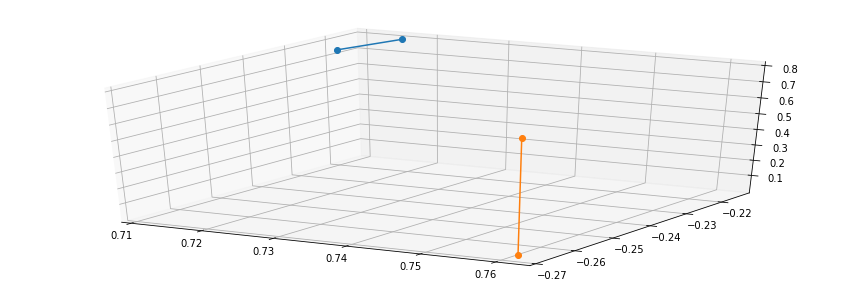

In [130]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))

idx_col = 205

sub = fig.add_subplot(1, 1, 1, projection="3d")
x, y, z = np.transpose(vtx2_list[idx1_list[idx_col]])
sub.plot(x, y, z, '-o')
x, y, z = np.transpose(vtx2_list[idx2_list[idx_col]])
print(GeometryItem.GLOBAL_GEO_LIST[idx1_list[idx_col]].name)
print(GeometryItem.GLOBAL_GEO_LIST[idx2_list[idx_col]].name)
sub.plot(x, y, z, '-o')
# sub.view_init(0, 90)

In [25]:
# np.save("vtx_list", vtx_list)
# np.save("radius_list", radius_list)
# np.save("idx1_list", idx1_list)
# np.save("idx2_list", idx2_list)

# test time

In [23]:
gtimer.reset()
found_vec = []
for _ in range(10):
    objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
        detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
    objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
    xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
        objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
    update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
    graph.show_pose(ZERO_JOINT_POSE)
    
    dt_sim = 0.04
    T_step = 10
    N_fullstep = int(T_step / dt_sim)
    initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))

    goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
    # goal_nodes = goal_nodes[3:4]

    graph.search_graph_mp(
        initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=True,
        tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
        **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)
    found_vec.append(len(schedule_sorted)>0)
print(gtimer)


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.1 s, steps/err: 250(1000.82087517 ms)/0.118931974288)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.15 s, steps/err: 250(1110.14890671 ms)/0.572747027797)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.31 s, steps/err: 250(1170.57013512 ms)/0.255064965093)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.37 s, steps/err: 250(1222.55396843 ms)/0.335583394457)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.43 s, steps/err: 250(1372.00188637 ms)/0.264198532646)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.01 s, steps/err: 250(1274.12700653 ms)/0.0325991536716)===== cut by swept volume test =====


fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.04 s, steps/err: 250(1142.34304428 ms)/0.138861874778)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)


fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (3.05 s, steps/err: nan(103.461027145 ms)/nan)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.07 s, steps/err: 250(1319.00119781 ms)/0.377650917112)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.07 s, steps/err: 250(1229.81286049 ms)/0.249519021404)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)


node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 1->5 (3.1 s, steps/err: 25(358.641147614 ms)/0.0008851151

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.72 s, steps/err: 250(1501.99890137 ms)/0.298842026036)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (1.87 s, steps/err: nan(96.0459709167 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.03 s, steps/err: nan(87.7258777618 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.07 s, steps/err: 250(1307.56998062 ms)/0.0637795853392)=============================================================================================================================================

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.35 s, steps/err: nan(88.4380340576 ms)/nan)===== cut by swept volume test =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.4 s, steps/err: nan(99.133014679 ms)/nan)===== cut by swept volume test =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.42 s, steps/err: nan(114.203214645 ms)/nan)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.44 s, steps/err: 250(1072.83306122 ms)/0.0833587008642)======================================================================================================================================================


fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.44 s, steps/err: nan(68.3579444885 ms)/nan)node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)
nod


fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.06 s, steps/err: 250(1468.8949585 ms)/0.252214559158)======================================================================================================================================================

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (5.4 s, steps/err: 250(1703.19199562 ms)/0.327042422697)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.53 s, steps/err: 250(2051.46384239 ms)/0.168655449131)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (5.72 s, steps/err: 250(246.978998184 ms)/1.00317159237)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'left_p', 'goal_bd'),)
unknown eTaSL exception: optimization fail

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 3->9 (8.32 s, steps/err: 3(249.050140381 ms)/0.00093800215154)======================================================================================================================================================

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (8.57 s, steps/err: 250(1140.52915573 ms)/0.247449012585)
unknown eTaSL exception: optimization failed during execution
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (8.61 s, steps/err: 250(297.981023788 ms)/0.389189960612)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (9.46 s, steps/err: 250(1

===== terminate =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (11.37 s, steps/err: 250(1190.16695023 ms)/0.492559053397)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
===== terminate =====

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.44 s, steps/err: 66(330.087900162 ms)/0.00080156023875)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.11 s, steps/err: 250(1079.16402817 ms)/0.272924902386)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.24 s, steps/err: 250(1062.50810623 ms)/0.361908521627)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.24 s, steps/err: 250(1187.73412704 ms)/0.37785471045)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init c


fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.54 s, steps/err: 250(1040.50087929 ms)/0.484772409357)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.57 s, steps/err: 250(1072.97611237 ms)/0.0735977697013)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.06 s, steps/err: 250(1408.83088112 ms)/0.0717858405763)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.09 s, steps/err: 250(1564.59116936 ms)/0.250316227315)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.25 s, steps/err: 250(1629.93192673 ms)/0.0648180569405)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (4.82 s,


fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.06 s, steps/err: nan(93.8811302185 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.07 s, steps/err: nan(142.858982086 ms)/nan)


node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (7.09 s, steps/err: 250(1487.64801025 ms)/0.151132838564)node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 1->6 (7.19 s, steps/err: 25(465.757131577 ms)/0.000659348677593)====================================
===== cut by swept volume test =====
===== cut by swept volume test =====

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.2 s, steps/err: nan(70.476055145


fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.63 s, steps/err: 250(1390.05994797 ms)/0.0573024690892)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.74 s, steps/err: 250(1507.4160099 ms)/0.0419634474597)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (8.83 s, steps/err: nan(102.788925171 ms)/nan)====================================
===== cut by swept volume test =====

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (8.87 s, steps/err: nan(72.0059871674 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 2->8 (8.93 s, steps/err: 24(268.784999847 ms)/0.000914546939844)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 


===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (11.12 s, steps/err: nan(87.2941017151 ms)/nan)===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)
===== cut by swept volume test =====

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.15 s, steps/err: nan(74.0349292755 ms)/nan)======================================================================================================================================================

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.15 s, steps/err: nan(41.8009757996 ms)/nan)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.17 s, steps/err: nan(83.3427906036 ms)/nan)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (11.16 s, s


fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (11.61 s, steps/err: 250(1196.38299942 ms)/0.034095465483)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 2->11 (12.07 s, steps/err: 120(627.940893173 ms)/0.000885141269648)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'grip1'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 3->12 (12.21 s, steps/err: 90(729.660987854 ms)/0.000883947143208)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'right_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 6->13 (12.36 s, steps/err: 137(916.426897049 ms)/0.000844820747416)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'grip1'),)

success - Goal cost:1->1 / Init cost:1->2 / branching: 3->14 (12.68 s, steps/err: 145(1163.19298744 ms)/0.000882040211618)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1-


fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (16.42 s, steps/err: 250(1173.98905754 ms)/0.0381224568166)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (16.5 s, steps/err: 250(1858.46590996 ms)/0.251189733461)======================================================================================================================================================

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 12-> (16.62 s, steps/err: 250(995.970010757 ms)/0.319814467752)===== cut by swept volume test =====

node: (('box1', 'right_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (16.67 s, steps/err: nan(96.5669155121 ms)/nan)================================================================================================================================================


node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.15 s, steps/err: 250(1257.39502907 ms)/0.156804984863)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (3.43 s, steps/err: 250(1697.94893265 ms)/0.583400909246)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.75 s, steps/err: 250(1157.351017 ms)/0.352728326186)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 2-> (3.77 s, steps/err: 250(1088.06490898 ms)/0.221046542956)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 1->3 (3.86 s, steps/err: 75(621.671915054 ms)/0.000920452716558)
node:

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.09 s, steps/err: nan(81.0148715973 ms)/nan)====================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.13 s, steps/err: nan(109.30109024 ms)/nan)====================================

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (6.2 s, steps/err: nan(113.448143005 ms)/nan)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 1-> (6.23 s, steps/err: 250(1196.12598419 ms)/0.230753209866)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / bra


fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (9.43 s, steps/err: 250(1645.67899704 ms)/0.539085572406)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (9.72 s, steps/err: 250(1208.88113976 ms)/0.232692047164)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (9.74 s, steps/err: 250(1704.76102829 ms)/0.245073053011)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (9.88 s, steps/err: 250(1348.20914268 ms)/0.0601248745907)====================================
===== cut by swept volume test =====


fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (9.94 s, steps/err: nan(121.962070465 ms)/nan)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
==


fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (12.48 s, steps/err: 250(1267.49396324 ms)/0.240822646552)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (12.66 s, steps/err: 250(1597.09405899 ms)/0.384742993885)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (12.72 s, steps/err: 250(1656.9879055 ms)/0.232506155969)======================================================================================================================================================

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (12.85 s, steps/err: 250(1438.92002106 ms)/0.0403740758045)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 11-> (12.82 s, steps/err: 250(1479.52485085 ms)/0.533874291464)

node: (('box1', 'front_p', 'vac2'),)->(('box1', '

===== cut by swept volume test =====
===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (15.8 s, steps/err: nan(96.7619419098 ms)/nan)====================================


fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (15.83 s, steps/err: nan(68.4309005737 ms)/nan)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->13 (15.83 s, steps/err: 36(330.225944519 ms)/0.000748730370857)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 12-> (15.83 s, steps/err: 250(1075.90508461 ms)/0.0272648636678)node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (15.85 s, steps/err: nan(154.696941376 ms)/nan)======================================================================================================================================================

node: (('

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 14-> (18.93 s, steps/err: nan(100.581884384 ms)/nan)======================================================================================================================================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->15 (19.28 s, steps/err: 24(300.82321167 ms)/0.000865480994096)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 0->16 (19.34 s, steps/err: 30(386.841058731 ms)/0.000861237961819)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 14->18 (19.48 s, steps/err: 128(659.820079803 ms)/0.000983792718635)
success - Goal cost:2->2 / Init cost:0->0 / branching: 0->17 (19.48 s, steps/err: 23(422.82009124

fail - Goal cost:1->0 / Init cost:1->2 / branching: 22-> (27.53 s, steps/err: 250(1258.63695145 ms)/0.245195141826)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (27.74 s, steps/err: 250(1330.80196381 ms)/0.238077508456)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 17-> (27.77 s, steps/err: 250(1435.41193008 ms)/0.370108568582)node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (27.9 s, steps/err: 250(958.818912506 ms)/0.234132194495)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 15-> (28.05 s, steps/err: 250(1591.57800674 ms)/0.461930021947)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 16-> (28.12 s, st


fail - Goal cost:1->0 / Init cost:1->2 / branching: 24-> (31.04 s, steps/err: 250(1440.00792503 ms)/0.3040306951)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (31.13 s, steps/err: nan(123.47817421 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 24-> (31.23 s, steps/err: 250(1527.10103989 ms)/0.249572482139)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (31.23 s, steps/err: nan(106.04095459 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (31.29 s, steps/err: nan(85.5329036713 ms)/nan)====================================
===== cut by swept volum


success - Goal cost:1->1 / Init cost:1->1 / branching: 22->26 (32.83 s, steps/err: 114(675.616979599 ms)/0.000943202786055)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 25-> (32.87 s, steps/err: 250(1449.38802719 ms)/0.0336727818415)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'grip1'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 25-> (33.01 s, steps/err: 250(1593.58406067 ms)/0.198271139017)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 22->27 (33.11 s, steps/err: 24(310.496091843 ms)/0.000941195895209)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 22->28 (33.37 s, steps/err: 188(1296.71096802 ms)/0.000964872126797)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'grip1'),)

success - Goal cost:1->1 / Init cost:1->1 /

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (36.91 s, steps/err: nan(98.6168384552 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 22-> (36.91 s, steps/err: nan(103.389978409 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 27-> (36.97 s, steps/err: 250(1223.12998772 ms)/0.302575102537)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 26-> (37.06 s, steps/err: 250(1522.90201187 ms)/0.224736138716)===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 0-> (37.08 s, steps/err: nan(98.7808704376 ms)/nan)

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p'


fail - Goal cost:1->0 / Init cost:1->2 / branching: 31-> (38.98 s, steps/err: 250(1247.73192406 ms)/0.348206695596)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 30-> (39.11 s, steps/err: 250(1735.41498184 ms)/0.248537797185)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 30-> (39.19 s, steps/err: 250(1691.77293777 ms)/0.0850227208828)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 30->32 (39.33 s, steps/err: 73(559.69786644 ms)/0.000941926638543)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 31-> (39.54 s, steps/err: 250(1468.0659771 ms)/0.0710781258871)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 31

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 33-> (42.92 s, steps/err: 250(1530.90810776 ms)/0.65231710745)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 35-> (42.94 s, steps/err: 250(1281.0280323 ms)/0.8760621867)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 34-> (42.96 s, steps/err: 250(1421.73790932 ms)/0.523406699939)

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
unknown eTaSL exception: optimization failed during execution
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 34-> (42.98 s, steps/err: 250(267.253875732 ms)/0.874840095161)
fail - Goal cost:1->1 / Init cost:1->2 / branching: 32-> (42.97 s, steps/err: 250(2174.76606369 ms)/0.171319709285)=========================================================================

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (44.96 s, steps/err: nan(95.3068733215 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (44.97 s, steps/err: nan(91.3009643555 ms)/nan)====================================


===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (45.01 s, steps/err: nan(82.4480056763 ms)/nan)======================================================================================================================================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====
===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 32-> (45.17 

fail - Goal cost:2->1 / Init cost:0->1 / branching: 40-> (48.48 s, steps/err: 250(1241.95098877 ms)/0.217940491908)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 40-> (48.56 s, steps/err: 250(1233.64496231 ms)/0.157854396946)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 40-> (48.86 s, steps/err: 250(1596.18496895 ms)/0.283291045663)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (49.01 s, steps/err: 250(1231.26912117 ms)/0.0798910788392)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (49.09 s, steps/err: 250(1452.63004303 ms)/0.


node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (52.43 s, steps/err: 250(1442.84892082 ms)/0.575250893335)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (52.9 s, steps/err: 250(1363.31582069 ms)/0.274956792263)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (52.91 s, steps/err: 250(1371.79708481 ms)/0.095079756148)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 42-> (52.93 s, steps/err: 250(416.836023331 ms)/0.854539871933)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 39-> (53.07 s, steps/err: 250(1428.52902412 ms)/0.168935990785)
node: 


fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (55.35 s, steps/err: 250(1253.70502472 ms)/0.143524449632)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 41-> (55.52 s, steps/err: 250(1313.3149147 ms)/0.231650319967)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 44-> (55.77 s, steps/err: 250(1041.15700722 ms)/0.33445598017)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 45-> (56.06 s, steps/err: 250(1180.31001091 ms)/0.231885583391)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 44-> (56.21 s, steps/err: 250(1486.36603355 ms)/0.247953297851)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 45-> (56.24 s, steps/err: 250(1434.35692787 ms)/0.702663332822)
fail - Goal cost:2->1 / Ini


fail - Goal cost:2->1 / Init cost:0->1 / branching: 49-> (62.21 s, steps/err: 250(1194.98801231 ms)/0.405115230742)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 48-> (62.26 s, steps/err: 250(1020.05791664 ms)/0.344758893861)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 49-> (62.33 s, steps/err: 250(1145.36499977 ms)/0.358152322992)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 50-> (62.5 s, steps/err: 250(1166.847229 ms)/0.383678299068)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 50-> (62.52 s, steps/err: 250(1215.24500847 ms)/0.0330055363304)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goa


fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (65.54 s, steps/err: 250(1107.31005669 ms)/0.16273457055)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (65.99 s, steps/err: 250(1486.55486107 ms)/0.287637304087)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (65.98 s, steps/err: 250(1468.8937664 ms)/0.133315967422)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (66.06 s, steps/err: 250(1220.92700005 ms)/0.409504882535)====================================


fail - Goal cost:2->1 / Init cost:0->1 / branching: 52-> (66.11 s, steps/err: 250(1056.35905266 ms)/0.23389483756)===== cut by swept volume test =====

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'

fail - Goal cost:1->0 / Init cost:1->2 / branching: 57-> (71.28 s, steps/err: 250(1378.17311287 ms)/0.0325937793943)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 54-> (71.27 s, steps/err: 250(1072.13592529 ms)/0.453512808678)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 56-> (71.28 s, steps/err: 250(1437.67786026 ms)/0.305210038218)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 54-> (71.57 s, steps/err: 250(1245.98097801 ms)/0.238232609594)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 54-> (71.64 s, steps/err: 250(1158.76102448 ms)/0.0762026489185)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 55-> (71.82 

===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (74.11 s, steps/err: nan(81.4380645752 ms)/nan)
success - Goal cost:2->2 / Init cost:0->0 / branching: 30->59 (74.12 s, steps/err: 31(424.01099205 ms)/0.000777916883584)====================================


fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (74.14 s, steps/err: nan(125.935792923 ms)/nan)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 58-> (74.2 s, steps/err: 250(1550.10604858 ms)/0.0773323972827)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Go


fail - Goal cost:2->1 / Init cost:0->1 / branching: 59-> (77.3 s, steps/err: 250(1247.56908417 ms)/0.582352329101)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 61-> (77.68 s, steps/err: 250(1143.06902885 ms)/0.369293745369)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (77.92 s, steps/err: 250(1244.53806877 ms)/0.257465461789)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (78.06 s, steps/err: 250(1086.21907234 ms)/0.248600481449)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (78.29 s, steps/err: 250(1488.1298542 ms)/0.582434323757)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 62-> (78.31 s, steps/err: 250(1177.39200592 ms)/0.310443472182)

node: (('box1', 'back_p'


fail - Goal cost:1->0 / Init cost:1->2 / branching: 66-> (84.25 s, steps/err: 250(1289.40010071 ms)/0.245810387514)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 66-> (84.37 s, steps/err: 250(1678.26700211 ms)/0.235956380943)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 65-> (84.45 s, steps/err: 250(1197.11589813 ms)/0.331106843972)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 65-> (84.63 s, steps/err: 250(1480.37981987 ms)/0.212378950946)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 65-> (84.83 s, steps/err: 250(1620.84794044 ms)/0.275170402605)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 67-> (85.02 s


success - Goal cost:2->1 / Init cost:0->1 / branching: 69->70 (87.42 s, steps/err: 83(416.342973709 ms)/0.000943879171272)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 68-> (87.76 s, steps/err: 250(1444.60511208 ms)/0.375052770755)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 69-> (87.76 s, steps/err: 250(1124.19700623 ms)/0.230590522186)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 69-> (87.95 s, steps/err: 250(1298.20513725 ms)/0.31960871341)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 68-> (88.05 s, steps/err: 250(1610.53705215 ms)/0.371354142162)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 69-> (88.22 


success - Goal cost:2->1 / Init cost:0->1 / branching: 72->75 (95.06 s, steps/err: 86(471.342086792 ms)/0.000946374136238)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 74-> (95.09 s, steps/err: 250(1516.75796509 ms)/0.0466299298157)node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 74-> (95.27 s, steps/err: 250(1320.00398636 ms)/0.249918476343)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 74-> (95.3 s, steps/err: 250(1183.33101273 ms)/0.303655308498)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 72-> (96.02 s, steps/err: 250(1193.15719604 ms)/0.500000780544)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 72-> (96.03 s, steps/err: 250(1203.20606232 ms)/0.0772454016394)
node: (


fail - Goal cost:2->1 / Init cost:0->1 / branching: 77-> (102.38 s, steps/err: 250(1115.64207077 ms)/0.247267518809)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 77-> (102.55 s, steps/err: 250(1232.88321495 ms)/0.242091396854)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 76-> (102.58 s, steps/err: 250(1415.32802582 ms)/0.591121751599)node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 77-> (102.63 s, steps/err: 250(1265.36798477 ms)/1.31841439905)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)
unknown eTaSL exception: optimization failed during execution

fail - Goal cost:2->1 / Init cost:0->1 / branching: 76-> (102.92 s, steps/err: 250(310.865879059 ms)/0.986115111774)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

succ


node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (106.37 s, steps/err: nan(100.394964218 ms)/nan)
===== cut by swept volume test =====
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 16-> (106.43 s, steps/err: nan(112.125873566 ms)/nan)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 82-> (106.45 s, steps/err: 250(1622.24698067 ms)/0.383317051478)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 82-> (106.48 s, steps/err: 250(1622.90716171 ms)/0.0260971078792)======================================================================================================================================================


node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)
node: (('box1', 'front_p', 'vac2'),)->(('box


fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (108.04 s, steps/err: 250(1322.9470253 ms)/0.256892546888)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (108.13 s, steps/err: 250(1353.55591774 ms)/0.695256877001)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 85-> (108.54 s, steps/err: 250(1408.03909302 ms)/0.57815424246)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (108.59 s, steps/err: 250(1803.33399773 ms)/0.579001429388)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 85-> (108.64 s, steps/err: 250(1301.93185806 ms)/0.371286695127)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 84-> (108.7


fail - Goal cost:2->1 / Init cost:0->1 / branching: 84-> (112.24 s, steps/err: 250(1242.95401573 ms)/0.33525756624)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (112.67 s, steps/err: 250(1201.03979111 ms)/0.26064086847)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (112.86 s, steps/err: nan(129.917860031 ms)/nan)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 2-> (113.02 s, steps/err: nan(68.0480003357 ms)/nan)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 83-> (113.01 s, steps/err: 250(1572.1681118 ms)/0.16837248745)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)
===== cut by swep

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
===== cut by swept volume test =====

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.51 s, steps/err: nan(51.146030426 ms)/nan)
fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.5 s, steps/err: nan(72.9920864105 ms)/nan)===== cut by swept volume test =====

success - Goal cost:2->2 / Init cost:0->0 / branching: 2->87 (113.51 s, steps/err: 23(374.119997025 ms)/0.000867435602622)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)


node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.54 s, steps/err: nan(118.931055069 ms)/nan)====================================
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

===== cut by swept volume test =====
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->2 / Init cost:0->0 / branching: 13-> (113.6


fail - Goal cost:1->0 / Init cost:1->2 / branching: 88-> (116.48 s, steps/err: 250(1470.67809105 ms)/0.0548717207944)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 89->90 (117.09 s, steps/err: 51(548.645019531 ms)/0.000843473306808)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 89-> (117.13 s, steps/err: 250(1305.66096306 ms)/0.578712025128)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 89-> (117.14 s, steps/err: 250(1426.03087425 ms)/0.419702255212)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 89-> (117.28 s, steps/err: 250(1142.77


fail - Goal cost:2->2 / Init cost:0->0 / branching: 16-> (121.95 s, steps/err: 250(938.414096832 ms)/0.103115360382)
success - Goal cost:2->2 / Init cost:0->0 / branching: 1->95 (121.95 s, steps/err: 27(353.986024857 ms)/0.000714432514165)

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

success - Goal cost:2->2 / Init cost:0->0 / branching: 1->96 (122.0 s, steps/err: 24(397.62711525 ms)/0.000673514100392)======================================================================================================================================================

node: (('box1', 'back_p', 'floor'),)->(('box1', 'back_p', 'floor'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 94-> (123.02 s, steps/err: 250(1351.08208656 ms)/0.588490685825)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 93-> (123.09 s, steps/err: 250(1367.6


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.98 s, steps/err: 250(1413.41304779 ms)/0.254360230045)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.11 s, steps/err: 250(1478.0600071 ms)/0.271950835358)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.3 s, steps/err: nan(96.0419178009 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.42 s, steps/err: 250(1477.71310806 ms)/0.0265615406971)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.59 s, steps/err: nan(96.0059165955 ms)/nan)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

success - Goal cost:1->1 / 


fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (4.18 s, steps/err: 250(1055.40800095 ms)/0.513776122706)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)
===== terminate =====

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.82 s, steps/err: 63(454.733848572 ms)/0.000939380730587)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.15 s, steps/err: 250(1015.83003998 ms)/0.082375130091)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.17 s, steps/err: 250(1125.96702576 ms)/0.25585924024)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.16 s, steps/err: 250(1081.0239315 ms)/0.339732352313)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.19 s, steps/err: 250(1124.27997589 ms)/0.584927953847)
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

node: (('

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (4.02 s, steps/err: 250(1179.48293686 ms)/0.384748749722)===== cut by swept volume test =====

node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (4.06 s, steps/err: nan(108.518123627 ms)/nan)======================================================================================================================================================

===== cut by swept volume test =====
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (4.13 s, steps/err: nan(107.182025909 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (4.16 s, steps/err: nan(70.4970359802 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', '

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (9.25 s, steps/err: 250(1263.07988167 ms)/0.810351715152)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->2 / branching: 1-> (9.49 s, steps/err: 250(2768.41807365 ms)/0.234015856784)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (9.62 s, steps/err: 250(1678.08818817 ms)/0.289699336319)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (9.68 s, steps/err: 250(1792.14811325 ms)/0.333025510039)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (10.12 s, steps/err: 250(1456.51984215 ms)/0.25542406997)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (10.24 s, s


node: (('box1', 'top_p', 'grip1'),)->(('box1', 'top_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (12.42 s, steps/err: 250(1909.80911255 ms)/0.32120506402)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 9-> (12.45 s, steps/err: 250(1336.37785912 ms)/0.0526229650193)

node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->0 / Init cost:1->2 / branching: 10-> (12.57 s, steps/err: 250(1968.87087822 ms)/0.173547803256)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (12.59 s, steps/err: nan(90.4340744019 ms)/nan)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'right_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)
===== cut by swept volume test =====

success - Goal cost:1->0 / Init cost:1->2 / branching: 11->12 (12.69 s, steps/err: 87(628.222942352 ms)/0.0008700774522


fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.11 s, steps/err: 250(1298.60091209 ms)/0.231600398969)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.47 s, steps/err: 250(1172.06406593 ms)/0.0497616680426)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.49 s, steps/err: 250(1291.51082039 ms)/0.237663650968)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.54 s, steps/err: 250(1250.46682358 ms)/0.246191578704)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (2.56 s, steps/err: 250(1131.43801689 ms)/0.0688012007679)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)
===== cut by swept volume test =====
===== cut by swept volume tes


fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (6.83 s, steps/err: 250(1883.30507278 ms)/0.31706852788)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (6.96 s, steps/err: 250(1626.51991844 ms)/0.0799856215802)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (7.62 s, steps/err: 250(1323.01592827 ms)/0.293607991616)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (7.79 s, steps/err: nan(95.0500965118 ms)/nan)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (7.79 s, steps/err: 250(1531.20183945 ms)/0.766940526878)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'top_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / bran


fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (8.59 s, steps/err: nan(154.929161072 ms)/2.80685548126)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1->1 / branching: 2->8 (8.77 s, steps/err: 130(720.036029816 ms)/0.000998508272955)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'top_p', 'grip1'),)
unknown eTaSL exception: first execution optimization failed
unknown eTaSL exception: first execution optimization failed

success - Goal cost:1->1 / Init cost:1->1 / branching: 3->9 (8.85 s, steps/err: 122(818.145990372 ms)/0.00095863735107)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (8.87 s, steps/err: nan(266.457080841 ms)/2.76747569772)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 7-> (8.87 s, steps/err: nan(273.030042648 ms)/3.62262417839)node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'left_p', 'vac2'),)



success - Goal cost:1->1 / Init cost:1->1 / branching: 6->10 (8.9 s, steps/err: 178

===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.68 s, steps/err: nan(86.0600471497 ms)/nan)====================================

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.75 s, steps/err: nan(107.095956802 ms)/nan)====================================

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.78 s, steps/err: 250(1081.86578751 ms)/0.592510470615)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)

===== cut by swept volume test =====
node: (('box1', 'back_p', 'floor'),)->(('box1', 'right_p', 'grip1'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (2.8 s, steps/err: nan(56.930065155 ms)/nan)======================================================================================================================================================

node: (('box1', 'front_p', 'vac


fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (5.87 s, steps/err: 250(1055.61709404 ms)/0.241558130449)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (5.9 s, steps/err: 250(1173.81811142 ms)/0.387954997974)node: (('box1', 'left_p', 'grip1'),)->(('box1', 'right_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (5.94 s, steps/err: 250(1142.27700233 ms)/0.414565430823)======================================================================================================================================================


node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'back_p', 'goal_bd'),)
===== cut by swept volume test =====
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (6.09 s, steps/err: nan(117.920875549 ms)/nan)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (6.1 s, steps/err: nan(115.292072296 ms)/nan)

node: ((

===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 6-> (7.83 s, steps/err: nan(75.2470493317 ms)/nan)

success - Goal cost:1->1 / Init cost:1->1 / branching: 4->7 (7.87 s, steps/err: 13(231.166124344 ms)/0.000720590730078)node: (('box1', 'front_p', 'vac2'),)->(('box1', 'front_p', 'vac2'),)


fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (7.9 s, steps/err: 250(985.430002213 ms)/0.243506637329)
node: (('box1', 'left_p', 'grip1'),)->(('box1', 'front_p', 'vac2'),)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.07 s, steps/err: 250(1017.52901077 ms)/0.236870395234)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 6-> (8.08 s, steps/err: 250(1299.05605316 ms)/0.0505813469285)
node: (('box1', 'front_p', 'vac2'),)->(('box1', 'right_p', 'goal_bd'),)

node: (('box1', 'front_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)

success - Goal cost:1->1 / Init cost:1



node: (('box1', 'top_p', 'vac2'),)->(('box1', 'left_p', 'goal_bd'),)

fail - Goal cost:1->1 / Init cost:1->1 / branching: 5-> (9.94 s, steps/err: nan(85.6850147247 ms)/nan)node: (('box1', 'top_p', 'vac2'),)->(('box1', 'back_p', 'goal_bd'),)
node: (('box1', 'top_p', 'grip1'),)->(('box1', 'top_p', 'grip1'),)
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (10.07 s, steps/err: nan(65.8750534058 ms)/nan)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 8-> (10.15 s, steps/err: 250(1027.59599686 ms)/0.0497824779625)====================================
===== cut by swept volume test =====

fail - Goal cost:1->1 / Init cost:1->1 / branching: 2-> (10.18 s, steps/err: nan(56.9179058075 ms)/nan)

node: (('box1', 'top_p', 'vac2'),)->(('box1', 'bottom_p', 'goal_bd'),)
node: (('box1', 'bottom_p', 'grip1'),)->(('box1', 'bottom_p', 'grip1'),)
===== cut by swept volume test ====

KeyboardInterrupt: 

In [ ]:
print("Success rate: {} %".format(np.mean(found_vec)*100))
print(gtimer)

In [ ]:
# SVT CASE
# Success rate: 100.0 %
# show_pose: 	637.0 ms/30 = 21.22 ms (18.16/27.518)
# search_graph_mp: 	99415.0 ms/30 = 3313.844 ms (1712.408/4521.561)
# init_search: 	57.0 ms/30 = 1.908 ms (1.497/7.065)
# score_graph: 	29.0 ms/240 = 0.122 ms (0.086/0.272)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.025)
# check_goal: 	4.0 ms/6177 = 0.001 ms (0.0/0.021)
# get_valid_neighbor: 	6.0 ms/540 = 0.011 ms (0.002/3.62)
# add_node_queue_leafs: 	113.0 ms/30 = 3.767 ms (2.884/5.323)
# find_schedules: 	28.0 ms/30 = 0.948 ms (0.604/1.509)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.022)

In [ ]:
# NO SVT CASE
# Success rate: 100.0 %
# show_pose: 	609.0 ms/30 = 20.284 ms (17.837/26.163)
# search_graph_mp: 	96204.0 ms/30 = 3206.813 ms (1566.82/4633.293)
# init_search: 	53.0 ms/30 = 1.753 ms (1.495/2.953)
# score_graph: 	28.0 ms/240 = 0.116 ms (0.088/0.312)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.022)
# check_goal: 	4.0 ms/6174 = 0.001 ms (0.0/0.015)
# get_valid_neighbor: 	2.0 ms/540 = 0.004 ms (0.002/0.026)
# add_node_queue_leafs: 	109.0 ms/30 = 3.65 ms (2.816/4.925)
# find_schedules: 	28.0 ms/30 = 0.941 ms (0.617/2.113)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.015)